# Convert stimuli generated in TDW to png then upload to s3
1. The first part of this notbeook converts hdf5 files generated in tdw into png files with the appropriate labels in the format: study_condition_stability_numBlocks_index.png (e.g. curiotower_varyhorizontal_unstable_8_0001.png)
2. The second part has some helpful analysis and can be used to visualize towers in the hdf5 format

In [2]:
#!pip install h5py
import warnings
import os
import h5py
import numpy as np
from PIL import Image 
import io
warnings.filterwarnings('ignore')


# 1. Function to convert hdf5 into png with new name
Takes a stimulus condition (varyHorizontal,varyScale, or varyNumber) and converts the first frame to a png with information on stability and num blocks

In [5]:
#condition = 'varyScale' 
#condition = 'varyHorizontal'
condition = 'varyNumber'

TDW_DIR = "../../tdw_physics/controllers/D:/{}/".format(condition)
PNG_DIR = "./tdw_png/"


idx = 0
for file in os.listdir(TDW_DIR):
    stability = "unstable" 
    if file.endswith('.hdf5'):
        f = h5py.File(os.path.join(TDW_DIR, file))
        frames = f['frames']
        frame = frames["%04d" % (0)]
        #Get block count
        numBlocks = str(len(frame['objects']['positions']))
        #Get index count
        index = str(idx).zfill(4)
        #Get stability
        if (((frames["%04d" % (0)]['objects']['positions'][-1][1])- 
             (frames["%04d" % (len(frames)-1)]['objects']['positions'][-1][1]))<0.2):
            stability = 'stable'
        img = frame['images']
        _img = Image.open(io.BytesIO(img["_img"][:]))
        new_filename = 'curiotower_' + condition + "_" + stability + "_" + numBlocks + "_" + index + ".png"
        _img.save(PNG_DIR+new_filename)
        #RENAME HDF5 WITH SAME INDEX
        os.rename(TDW_DIR+file, TDW_DIR+'curiotower_' + condition + "_" + stability + "_" + numBlocks + "_" + index + ".hdf5")
        idx+=1

# 2. Some helpful functions to analyze and visualize hdf5 files

### Visualize first, middle, and last frame of hdf5 file

top keys ['frames', 'static']
num frames: 42


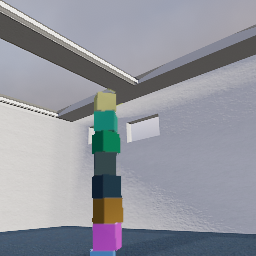

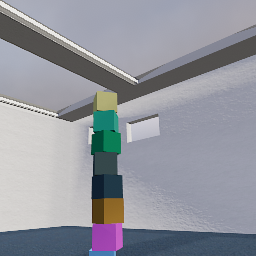

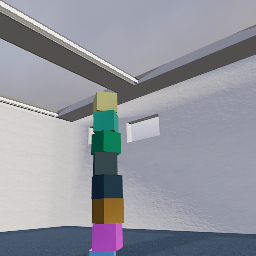

In [17]:
# #condition = 'varyScale' 
# #condition = 'varyHorizontal'
# condition = 'varyNumber'

# TDW_DIR = "../../tdw_physics/controllers/D:/{}/".format(condition)
TDW_DIR = "../../tdw_physics/controllers/D:/stability/"
FILE = "0011.hdf5"

f = h5py.File(os.path.join(TDW_DIR, FILE))
# print the data structure
print("top keys", [k for k in f.keys()])
frames = f['frames']
n_frames = len([k for k in frames.keys()])
print("num frames: {}".format(n_frames))
#view_frame = np.minimum(view_frame, n_frames - 1)
for view_frame in [0, 40, len(frames)-1]:
    frame = frames["%04d" % (view_frame)]
    img = frame['images']
    _img = Image.open(io.BytesIO(img["_img"][:]))
    display(_img)

## Function to classify stable, precarious, and unstable towers
- we define "unstable" as any tower that falls over (large delta in y-axis height from first to last frame)
- "precarious" towers are those that remain standing, but have an x-axis delta greater than the scale_factor/3
- "stable" towers are those that remain standing with x-axis delta smaller than scale_factor/3

## Calculate tower height
- is this on some meaningful absolute scale?
- how to account for viewing angle, etc...

In [38]:
TDW_DIR = "./controllers/D:/stability/"
#loop through generated hdf5 files
tower_heights = []
for file in os.listdir(TDW_DIR):
    if file.endswith('.hdf5'):
        f = h5py.File(os.path.join(TDW_DIR, file))
        frames = f['frames']
        #get height of tallest block (last placed) in first frame
        tower_heights.append(frames["%04d" % (0)]['objects']['positions'][-1][1])
        
        
print(tower_heights)

KeyError: "Unable to open object (object 'frames' doesn't exist)"

In [9]:
#To calculate precarious, get max difference in x-axis
def get_x_diff(num_objects = 1):
    min_x = 100
    max_x = -100
    for i in range(num_objects):
        min_x = min(frames["%04d" % (0)]['objects']['positions'][i][0], min_x)
        max_x = max(frames["%04d" % (0)]['objects']['positions'][i][0], max_x)
    return(max_x - min_x)

In [ ]:
#Stable if it does not fall over
#Precarious if max x-axis jitter is >1/4 scale
#unstable if falls over

## Hdf5 hierarchy

In [12]:
# static/    # Data that doesn't change per frame.
# ....object_ids
# ....mass
# ....static_friction
# ....dynamic_friction
# ....bounciness
# frames/    # Per-frame data.
# ....0000/    # The frame number.
# ........images/    # Each image pass.
# ............_img
# ............_id
# ............_depth
# ............_normals
# ............_flow
# ........objects/    # Per-object data.
# ............positions
# ............forwards
# ............rotations
# ............velocities
# ............angular_velocities
# ........collisions/    # Collisions between two objects.
# ............object_ids
# ............relative_velocities
# ............contacts
# ........env_collisions/    # Collisions between one object and the environment.
# ............object_ids
# ............contacts
# ........camera_matrices/
# .\...........projection_matrix
# ............camera_matrix
# ....0001/
# ........ (etc.)

## Inspect Elements of hdf5

In [13]:
FILE = "0001.hdf5"

f = h5py.File(os.path.join(TDW_DIR, FILE))
# print the data structure
print("top keys", [k for k in f.keys()])
frames = f['frames']

view_frame =1
frame = frames["%04d" % (view_frame)]
frame.keys()

<KeysViewHDF5 ['camera_matrices', 'collisions', 'env_collisions', 'images', 'objects']>

In [14]:
obj = frame['objects']
for key in obj.keys():
        print(obj[key])

<HDF5 dataset "angular_velocities": shape (8, 3), type "<f4">
<HDF5 dataset "forwards": shape (8, 3), type "<f4">
<HDF5 dataset "positions": shape (8, 3), type "<f4">
<HDF5 dataset "rotations": shape (8, 4), type "<f4">
<HDF5 dataset "velocities": shape (8, 3), type "<f4">


## Calculate stability

In [43]:
FILE = "0005.hdf5"

f = h5py.File(os.path.join(TDW_DIR, FILE))
# print the data structure
print("top keys", [k for k in f.keys()])
frames = f['frames']

view_frame =0

frame = frames["%04d" % (view_frame)]
obj = frame['objects']
print("Num objects:", len(obj['positions']))
for pos in obj['positions']:
    print(pos)
get_x_diff(len(obj['positions']))

top keys ['frames', 'static']
Num objects: 8
[ 7.1621157e-02  5.2154064e-07 -2.9947127e-03]
[0.03600192 0.22975333 0.00211591]
[-0.09174058  0.45969936  0.00163137]
[-0.00544818  0.6895851   0.01487954]
[0.04414408 0.9195708  0.00640471]
[-0.08474839  1.1494607  -0.01967816]
[ 0.00775537  1.3794758  -0.00299694]
[0.10478558 1.6094614  0.01069383]


0.19652615

In [17]:
#To calculate precarious, get max difference in x-axis
def get_x_diff(num_objects = len(obj['positions'])):
    min_x = 100
    max_x = -100
    for i in range(num_objects):
        min_x = min(frames["%04d" % (0)]['objects']['positions'][i][0], min_x)
        max_x = max(frames["%04d" % (0)]['objects']['positions'][i][0], max_x)
    return(max_x - min_x)

In [49]:
TDW_DIR = "./controllers/D:/stability/"
STABLE_DIR = "./controllers/D:/stable/"

scale_factor = 0.23

stable_towers = {}
precarious_towers = {}
unstable_towers = {}

#loop through generated hdf5 files
for file in os.listdir(TDW_DIR):
    if file.endswith('.hdf5'):
        f = h5py.File(os.path.join(TDW_DIR, file))
        frames = f['frames']
        
        frame = frames["%04d" % (0)]
        obj = frame['objects']
        #check if top block has moved down by more than one block length
        if (((frames["%04d" % (0)]['objects']['positions'][-1][1])- 
             (frames["%04d" % (len(frames)-1)]['objects']['positions'][-1][1]))<0.2):
            if(get_x_diff(len(obj['positions'])) > scale_factor/2):
                precarious_towers[file] = get_x_diff(len(obj['positions']))
            else:
                stable_towers[file] = get_x_diff(len(obj['positions']))
        else:
            unstable_towers[file] = get_x_diff(len(obj['positions']))
            #os.rename("./controllers/D:/stability/{}".format(file), "./controllers/D:/stable/{}".format(file))
print("Stable:", len(stable_towers), "| Precarious:", len(precarious_towers), "| Unstable:", len(unstable_towers))
print(stable_towers)                                              

Stable: 13 | Precarious: 0 | Unstable: 7
{'0000.hdf5': 0.05313666, '0017.hdf5': 0.08293782, '0001.hdf5': 0.03446407, '0006.hdf5': 0.080784045, '0007.hdf5': 0.06164322, '0012.hdf5': 0.007347323, '0004.hdf5': 0.00967929, '0008.hdf5': 0.019052664, '0009.hdf5': 0.075513095, '0005.hdf5': 0.034038514, '0013.hdf5': 0.10254289, '0002.hdf5': 0.00050380453, '0019.hdf5': 0.035791665}
